<h5 style="direction:rtl;" align="center">بسم الله الرحمن الرحیم</h5>
<br>
<h4 style="direction:rtl;" align="center">دانشگاه صنعتی شریف - بهار ۱۴۰۲</h4>
<h4 style="direction:rtl;" align="center">دانشکده مهندسی کامپیوتر</h4>
<h3 style="direction:rtl;" align="center">فاز اول پروژه درس سامانه‌های یادگیری ماشین</h3>
<hr>
<div><h2 style="direction:rtl;" align="center">قسمت تقسیم بندی دادگان و داده‌افزایی</h2><div>
<hr>
<h4 style="direction:rtl;" align="center">اعضای گروه: محمدحسین موثقی‌نیا، مهدی منوچهری، حمید مهتدی جعفری</h4>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split

In [2]:
reviews = pd.read_csv('./../data/normalized_data.csv')
reviews = reviews[['review_type', 'review_content']]
movies = pd.read_csv('./../data/final_normalized_movie.csv')
movies = movies[['movie_title', 'review_type', 'review_content', 'my_score']]

# Split data (train, validation, test)

### Split train, val and test review data

In [11]:
def save_dataset(x, y, file_path="./../data/dataset/reviews", phase="train"):
    data = {"x": x, "y": y}
    with open(f"{file_path}/{phase}.pkl", 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f'[Log] {phase} Data has been saved in \"{file_path}/{phase}.pkl\"')

In [13]:
x_data = reviews['review_content']
y_data = reviews['review_type']
X_rem, X_test, y_rem, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=42, stratify=y_data)
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.1, random_state=42, stratify=y_rem)
print(f"Train: {len(y_train)} ({(len(y_train)/len(y_data))*100:.0f}%)")
print(f"Val: {len(y_val)} ({(len(y_val)/len(y_data))*100:.0f}%)")
print(f"Test: {len(y_test)} ({(len(y_test)/len(y_data))*100:.0f}%)")
save_dataset(X_train, y_train, file_path="./../data/dataset/reviews", phase="train")
save_dataset(X_val, y_val, file_path="./../data/dataset/reviews", phase="val")
save_dataset(X_test, y_test, file_path="./../data/dataset/reviews", phase="test")

Train: 768835 (81%)
Val: 85427 (9%)
Test: 94919 (10%)
[Log] train Data has been saved in "./../data/dataset/reviews/train.pkl"
[Log] val Data has been saved in "./../data/dataset/reviews/val.pkl"
[Log] test Data has been saved in "./../data/dataset/reviews/test.pkl"


### Split train, val and test movie data

In [18]:
uniq_movies = np.unique(movies['movie_title'])
uniq_movies_rem, uniq_movies_test = train_test_split(uniq_movies, test_size=0.1, random_state=42)
uniq_movies_train, uniq_movies_val = train_test_split(uniq_movies_rem, test_size=0.1, random_state=42)

df_train = pd.DataFrame({"movie_title": uniq_movies_train})
df_train = df_train.join(movies.set_index('movie_title'), on='movie_title', how='inner')
df_val = pd.DataFrame({"movie_title": uniq_movies_val})
df_val = df_val.join(movies.set_index('movie_title'), on='movie_title', how='inner')
df_test = pd.DataFrame({"movie_title": uniq_movies_test})
df_test = df_test.join(movies.set_index('movie_title'), on='movie_title', how='inner')

print(f"Train:\n> movie: [{len(uniq_movies_train)} ({(len(uniq_movies_train)/len(uniq_movies))*100:.0f}%)] - all: [{len(df_train)} ({(len(df_train)/len(movies['movie_title']))*100:.0f}%)]")
print(f"Val:\n> movie: [{len(uniq_movies_val)} ({(len(uniq_movies_val)/len(uniq_movies))*100:.0f}%)] - all: [{len(df_val)} ({(len(df_val)/len(movies['movie_title']))*100:.0f}%)]")
print(f"Test:\n> movie: [{len(uniq_movies_test)} ({(len(uniq_movies_test)/len(uniq_movies))*100:.0f}%)] - all: [{len(df_test)} ({(len(df_test)/len(movies['movie_title']))*100:.0f}%)]")

df_train.to_csv("./../data/dataset/movies/train.csv")
df_val.to_csv("./../data/dataset/movies/val.csv")
df_test.to_csv("./../data/dataset/movies/test.csv")

Train:
> movie: [10414 (81%)] - all: [749011 (81%)]
Val:
> movie: [1158 (9%)] - all: [84389 (9%)]
Test:
> movie: [1286 (10%)] - all: [90588 (10%)]


# Augmentation and Imbalance handeling

In [ ]:
!pip install nlpaug
!pip install torch transformers sentencepiece
!pip install simpletransformers
!pip install nltk
!pip install gensim
!pip install librosa
!pip install sacremoses

from nlpaug.util.file.download import DownloadUtil
# DownloadUtil.download_word2vec(dest_dir='.') # Download word2vec model
# DownloadUtil.download_glove(model_name='glove.6B', dest_dir='.') # Download GloVe model
DownloadUtil.download_fasttext(model_name='wiki-news-300d-1M', dest_dir='.') # Download fasttext model

!wget http://nlpgrid.seas.upenn.edu/PPDB/eng/ppdb-2.0-tldr.gz
!gzip -d /content/ppdb-2.0-tldr.gz

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import nltk
import random
import time
import multiprocessing as mp
from sklearn.model_selection import train_test_split
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import os
from tqdm import tqdm
nltk.download('averaged_perceptron_tagger')

In [ ]:
os.environ["MODEL_DIR"] = './'
model_dir = './'

In [10]:
def print_statistic_reviews(reviews):
    reviews = pd.DataFrame(reviews)
    class_dict = {'Fresh': len(reviews[reviews['y'] == 'Fresh']), 
                    'Rotten': len(reviews[reviews['y'] == 'Rotten'])}
    plt.figure(figsize=(3,3))
    sns.barplot(x=list(class_dict.keys()), y=list(class_dict.values()))
    plt.title('Label distribution')
    plt.show()
    print(f"Fresh: {class_dict['Fresh']} \
    ({int(class_dict['Fresh']/(class_dict['Fresh'] + class_dict['Rotten'])*100)}%)")
    print(f"Rotten: {class_dict['Rotten']} \
    ({int(class_dict['Rotten']/(class_dict['Fresh'] + class_dict['Rotten'])*100)}%)")

In [23]:
class Augmentation:
    def __init__(self):
        self.spellingAug = naw.SpellingAug()
        # self.wordEmbsAug_insert = naw.WordEmbsAug(
        #                                 model_type='word2vec', 
        #                                 model_path=model_dir+'GoogleNews-vectors-negative300.bin',
        #                                 action="insert")
        # self.wordEmbsAug_substitute = naw.WordEmbsAug(
        #                                 model_type='word2vec', 
        #                                 model_path=model_dir+'GoogleNews-vectors-negative300.bin',
        #                                 action="substitute")
        self.fasttext_insert = naw.WordEmbsAug(
                                        model_type='fasttext', 
                                        model_path=model_dir+'wiki-news-300d-1M.vec',
                                        action="insert")
        self.fasttext_substitute = naw.WordEmbsAug(
                                        model_type='fasttext', 
                                        model_path=model_dir+'wiki-news-300d-1M.vec',
                                        action="substitute")
        self.synonymAug_wordnet = naw.SynonymAug(aug_src='wordnet')
        self.synonymAug_ppdb = naw.SynonymAug(aug_src='ppdb', model_path=model_dir + 'ppdb-2.0-tldr')
        self.keyboard = nac.KeyboardAug()
        self.randomCharAug_insert = nac.RandomCharAug(action="insert")
        self.randomCharAug_substitute = nac.RandomCharAug(action="substitute")
        self.randomCharAug_swap = nac.RandomCharAug(action="swap")
        self.randomCharAug_delete = nac.RandomCharAug(action="delete")
        self.splitAug = naw.SplitAug()
        self.backTranslationAug = naw.BackTranslationAug()

    def Word_Substitute_spelling(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Substitute word by spelling mistake words dictionary
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.spellingAug.augment(text, n=1)[0]
        else:
            return text
    
    def Word_Insert_w2v(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Insert word randomly by word embeddings similarity with word2vec
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.wordEmbsAug_insert.augment(text)[0]  # must return augmentation
        else:
            return text

    def Word_Substitute_w2v(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Substitute word by word2vec similarity
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.wordEmbsAug_substitute.augment(text)[0]  # must return augmentation
        else:
            return text
    
    def Word_Insert_fasttext(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Insert word randomly by word embeddings similarity with fasttext
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.fasttext_insert.augment(text)[0]  # must return augmentation
        else:
            return text

    def Word_Substitute_fasttext(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Substitute word by fasttext similarity
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.fasttext_substitute.augment(text)[0]  # must return augmentation
        else:
            return text
    
    def Word_Substitute_wordNet(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Substitute word by WordNet's synonym
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.synonymAug_wordnet.augment(text)[0]  # must return augmentation
        else:
            return text

    def Word_Substitute_ppdb(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Substitute word by PPDB's synonym
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.synonymAug_ppdb.augment(text)[0]  # must return augmentation
        else:
            return text
    
    def Keyboard(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Substitute character by keyboard distance
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            augmented_text = self.keyboard.augment(text)
            
            return augmented_text[0]
        else:
            return text

    def Char_Random_Insert(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Insert character randomly
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.randomCharAug_insert.augment(text)[0]  # must return augmentation
        else:
            return text
    
    def Char_Random_Substitute(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Substitute character randomly
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.randomCharAug_substitute.augment(text)[0]
        else:
            return text
    
    def Char_Random_Swap(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Swap character randomly
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.randomCharAug_swap.augment(text)[0]  # must return augmentation
        else:
            return text
    
    def Char_Random_Delete(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Delete character randomly
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.randomCharAug_delete.augment(text)[0]
        else:
            return text

    def Word_Split(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Split word to two tokens randomly
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.splitAug.augment(text)[0]  # must return augmentation
        else:
            return text
    
    def Back_Translation(self, text: str, probability_threshold=0.5) -> str:
        """
        Description:
            Back Translation Augmenter
        ----------
        Parameters:
        `text` : str
            The input text that must augment.
        `probability_threshold` : float, (default = 0.5)
            The probability threshold [0,1] gets a random number from 
            the `Uniform` distribution and if the value is less 
            than `probability_threshold` the text is not augmented 
            and vice-versa.
        """
        if np.random.uniform(0,1) >= probability_threshold:
            return self.backTranslationAug.augment(text)[0]
        else:
            return text
    
    def aug_flow(self, text: str, condition={'back_trans': True, 
                                              'word_subs_spell': True, 
                                              'substitute': True, 
                                              'insert': True, 
                                              'char': True, 
                                              'keyboard_word_split': True}):
        
        aug_text = text

        if condition['back_trans']:
            aug_text = self.Back_Translation(aug_text)
        
        if condition['word_subs_spell']:
            aug_text = self.Word_Substitute_spelling(aug_text)
        
        # Substitute
        if condition['substitute']:
            rNumber = np.random.uniform(0,1)
            if rNumber < 0.25:
                aug_text = self.Word_Substitute_wordNet(aug_text)
            elif rNumber < 0.5:
                aug_text = self.Word_Substitute_ppdb(aug_text)
            # elif rNumber < 0.6:
            #     aug_text = self.Word_Substitute_w2v(aug_text)
            elif rNumber < 0.75:
                aug_text = self.Word_Substitute_fasttext(aug_text)
            else:
                aug_text = aug_text
        
        # Insert
        if condition['insert']:
            rNumber = np.random.uniform(0,1)
            if rNumber < 0.5:
                aug_text = self.Word_Insert_fasttext(aug_text)
            # elif rNumber < 0.66:
            #     aug_text = self.Word_Insert_w2v(aug_text)
            else:
                aug_text = aug_text

        # Char
        if condition['char']:
            rNumber = np.random.uniform(0,1)
            if rNumber < 0.2:
                aug_text = self.Char_Random_Insert(aug_text)
            elif rNumber < 0.4:
                aug_text = self.Char_Random_Substitute(aug_text)
            elif rNumber < 0.6:
                aug_text = self.Char_Random_Swap(aug_text)
            elif rNumber < 0.8:
                aug_text = self.Char_Random_Delete(aug_text)
            else:
                aug_text = aug_text

        # Keyboard and word split
        if condition['keyboard_word_split']:
            rNumber = np.random.uniform(0,1)
            if rNumber < 0.25:
                aug_text = self.Keyboard(aug_text)
            elif rNumber < 0.5:
                aug_text = self.Word_Split(aug_text)
            elif rNumber < 0.75:
                aug_text = self.Keyboard(aug_text)
                aug_text = self.Word_Split(aug_text)
            else:
                aug_text = aug_text
        
        return aug_text

    def Augment_parallel(self, df, ratio=0.2):
        manager = mp.Manager()
        return_dict = manager.dict()
        count = mp.cpu_count()
        chunk_len = int(len(df)/count)
        process = []
        for i in range(count):
            tmp = None
            id = i
            if i < count - 1:
                tmp = mp.Process(target=self.Augment, args=(df.iloc[i*chunk_len:(i*chunk_len)+chunk_len], ratio, id, return_dict))
            else:
                tmp = mp.Process(target=self.Augment, args=(df.iloc[i*chunk_len:], ratio, id, return_dict))
            process.append(tmp)
            process[-1].start()
        for p in process:
            p.join()
        return return_dict.values()
    
    def Augment_sequential(self, df, ratio=0.2):
        if os.path.exists("./../data/dataset/reviews/tmp"):
            [os.remove(f"./../data/dataset/reviews/tmp/{t}") for t in os.listdir("./../data/dataset/reviews/tmp/")]
            os.removedirs("./../data/dataset/reviews/tmp")
        os.mkdir("./../data/dataset/reviews/tmp")
        chunk_len = int(len(df)/1000)
        for i in range(1000):
            tmp = None
            print(f'# Augment_sequential # iter: {i}/1000')
            if i < 1000:
                tmp = self.Augment(df.iloc[i*chunk_len:(i*chunk_len)+chunk_len], ratio, id=i, return_dict={})
            else:
                tmp = self.Augment(df.iloc[i*chunk_len:], ratio, id=i, return_dict={})
            tmp.to_csv(f'./../data/dataset/reviews/tmp/output_tmp_{i}.csv')
    
    def Augment(self, df, ratio=0.2, id=1, return_dict={}):
        print(f"Augment_function - code-pid: {id} - len-data: {len(df)}") 
        condition={'back_trans': False, 'word_subs_spell': True, 'substitute': True, 
                   'insert': True, 'char': False, 'keyboard_word_split': False}
        aug_tmp = df.copy()
        aug_tmp = aug_tmp.sample(int(ratio*len(aug_tmp)))
        tmp = []
        for idx, x in enumerate(aug_tmp['x']):
            tmp.append(self.aug_flow(x, condition))
            if idx != 0 and idx%10==0:
                print(f"pid: {id} - iter: {idx}/{len(aug_tmp['x'])}")
        aug_tmp['x'] = tmp
        aug_dataset = [df]
        if ratio > 0:
            labels = np.unique(list(aug_tmp['y']))
            for l in labels:
                tmp = aug_tmp[aug_tmp['y'] == l].sample(int(len(aug_tmp[aug_tmp['y'] == l])*ratio))
                aug_dataset.append(tmp)
        else:
            aug_dataset = aug_tmp
        aug_dataset = pd.concat(aug_dataset)
        return_dict[id] = aug_dataset
        return aug_dataset

    def Upsample_less_number_class(self, x, y, ratio=1):
        label_number = {}
        labels = np.unique(y)
        for l in labels:
            label_number[l] = 0
        for t in y:
            label_number[t] += 1
        tmp = label_number.copy()
        for l in labels:
            tmp[l] = max(label_number.values())*(ratio)/label_number[l]
        label_number = tmp.copy()
        tmp = None
        print(label_number)
        df = {'x': x, 'y':y}
        df = pd.DataFrame(df)
        frame = []
        for l in labels:
            label_number[l] -= 1
            df_tmp = df[df['y']==l].copy()
            while label_number[l] >= 1:
                df_tmp = pd.concat([df_tmp, df[df['y']==l]])
                label_number[l] -= 1
            if label_number[l] > 0:
                tmp = df[df['y']==l].sample(int(label_number[l]*len(df[df['y']==l])))
                df_tmp = pd.concat([df_tmp, tmp])
            frame.append(df_tmp)
        frame = pd.concat(frame)
        frame = frame.sample(frac=1)
        frame.reset_index(drop=True, inplace=True)
        return frame

Create object from `Augmentation` class:

In [ ]:
aug = Augmentation()

Reading `Train` data for augmentation:

In [4]:
with open('./../data/dataset/reviews/train.pkl', 'rb') as f:
    train_data = pickle.load(f)

Plotting distribution of labels of data:

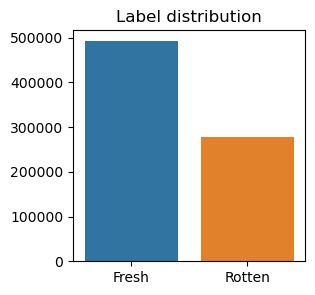

Fresh: 491949     (63%)
Rotten: 276886     (36%)


In [7]:
print_statistic_reviews(train_data)

**Upsample_less_number_class** : Data upsampling with `ratio=1`, that it takes enough samples from the class with the least sample to be equal to the class with the largest number. If the value of this variable is greater than 1, the class with the largest number will be multiplied by this value and then all other classes will be increased by this number of classes by increasing the data.

**Augment_sequential** : Then, by using data augmentation, according to the ratio determined in variable `ratio`, the data undergoes random changes including the functions defined in the `Augmentation` class.

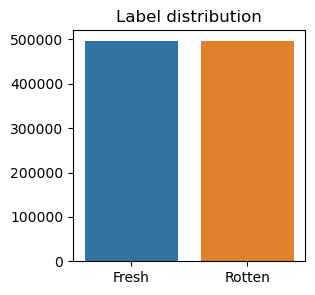

Fresh: 495942     (49%)
Rotten: 495946     (50%)


In [16]:
train_df = aug.Upsample_less_number_class(train_data['x'], train_data['y'], ratio=1)
aug.Augment_sequential(train_df, ratio=0.1)
files = os.listdir('./../data/dataset/reviews/tmp/')
frames = []
for f in files:
    tmp = pd.read_csv(f"./../data/dataset/reviews/tmp/{f}")
    frames.append(tmp)
frames = pd.concat(frames)
frames.drop(frames.columns[0], axis=1, inplace=True)
frames.reset_index(drop=True, inplace=True)
[os.remove(f"./../data/dataset/reviews/tmp/{t}") for t in os.listdir("./../data/dataset/reviews/tmp/")]
os.removedirs("./../data/dataset/reviews/tmp")
print_statistic_reviews(frames)

In [11]:
data = {"x": list(frames['x']), "y": list(frames['y'])}
with open("./../data/dataset/reviews/train_aug.pkl", 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)